## Preprocessing

training corpus: 2001 year, 8717 docs

In [1]:
import zipfile
from zipfile import ZipFile

In [2]:
# открываем зипфайл и читаем его
with zipfile.ZipFile("C:\\tmdasha\\MUNru.zip", 'r') as z:
  z.extractall('MUN')

print('Done')

Done


In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dvb07\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Сохраняем наши стоп-слова
with open('C:\\tmdasha\\stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

# Загружаем дополнительно стоп-слова из NLTK
stop_words.extend(stopwords.words('russian'))
# Избавляемся от дубликатов
stw = list(stop_words)

In [5]:
#print(stw)

In [6]:
import os

In [7]:
corpus_files = os.listdir('MUN/MUN')

In [8]:
import pymorphy2 as pm
morph = pm.MorphAnalyzer()

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dvb07\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
docs = []

# Предобрабатываем данные (предобработка одинаковая для всех моделей)
for ind, txt in enumerate(corpus_files):
    with open('MUN/MUN//' + txt, 'r', encoding='utf-8') as f:
        text = nltk.word_tokenize(f.read().lower())
        text = [token for token in text if len(token) > 2]
        text = [morph.parse(token)[0].normal_form for token in text if token not in stop_words]
        # Each document should contain lemmatized words separated by spaces
        docs.append(' '.join(text))

In [10]:
#print(docs)


---


---



## ScikitLearn

In [11]:
N_FIRST = 10  # сколько первых слов на тему выводить
MIN_DF = 5  # минимальное число вхождений слова в документ, 
            # чтобы мы его учитывали (включали в вектор документа)
MAX_DF = 0.95  # в каком проценте документов должно присутствовать слово,
               #  чтобы оно не рассматривалось

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
docs = list(docs)

In [14]:
vectorizer = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF,
                                   stop_words=stw)
docs_vectorized = vectorizer.fit_transform(docs)

C:\Users\dvb07\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ак', 'акад', 'буль', 'вкз', 'гр', 'дисс'] not in stop_words.
  warnings.warn(


In [15]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=20, learning_method='batch', batch_size=512, random_state=2)
lda_model.fit_transform(docs_vectorized)

array([[1.97976221e-01, 2.71443659e-02, 1.77952192e-01, ...,
        1.88668192e-02, 2.69707077e-01, 3.93116053e-02],
       [5.65128852e-04, 3.62806223e-01, 5.65138728e-04, ...,
        2.23826526e-01, 7.52266672e-02, 9.98364039e-02],
       [3.43805676e-01, 9.45450133e-05, 4.68844896e-01, ...,
        8.08705223e-02, 9.45444011e-05, 5.15700728e-03],
       ...,
       [1.52880163e-03, 3.92011387e-03, 6.90437854e-02, ...,
        6.12665042e-06, 6.12668893e-06, 8.28523852e-01],
       [2.18006003e-03, 1.45110225e-01, 1.42307564e-01, ...,
        9.50092203e-06, 9.50141122e-06, 3.89655954e-01],
       [4.78265731e-06, 1.31083714e-01, 1.59286766e-01, ...,
        4.78263744e-06, 6.43881619e-04, 3.38358067e-01]])

In [16]:
def print_topics(model, vectorizer, out, top_n=5):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        out.append([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[ :-top_n- 1:-1]])
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [17]:
lda_all_topics = []

print_topics(lda_model, vectorizer, out=lda_all_topics)

Topic 0:
[('безопасность', 28758.375101043654), ('совет', 25870.265783466715), ('оружие', 17157.31037434004), ('организация', 13601.766622750667), ('республика', 13306.437996990768)]
Topic 1:
[('комитет', 52534.29820170355), ('генеральный', 45004.04213652854), ('резолюция', 39652.83612246942), ('организация', 38465.774401143804), ('сессия', 34801.48288238351)]
Topic 2:
[('quot', 23254.309829334296), ('должный', 13903.769873931804), ('транспортный', 10208.840552034046), ('средство', 9276.686574654164), ('пункт', 8394.29480637358)]
Topic 3:
[('организация', 28366.412541054626), ('международный', 27827.727775767413), ('должный', 25952.870501762514), ('мир', 21992.71530348962), ('страна', 21548.283213762286)]
Topic 4:
[('сша', 31168.553051138668), ('организация', 23734.055653728064), ('объединить', 18907.914653481286), ('расход', 18312.696635671666), ('нация', 17502.304793312655)]
Topic 5:
[('женщина', 33060.79945107836), ('ребёнок', 22074.79215292249), ('quot', 15177.052643930803), ('прав

In [18]:
for i,topic in enumerate(lda_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

-------------------------------
Тема  0
безопасность
совет
оружие
организация
республика
-------------------------------
Тема  1
комитет
генеральный
резолюция
организация
сессия
-------------------------------
Тема  2
quot
должный
транспортный
средство
пункт
-------------------------------
Тема  3
организация
международный
должный
мир
страна
-------------------------------
Тема  4
сша
организация
объединить
расход
нация
-------------------------------
Тема  5
женщина
ребёнок
quot
право
образование
-------------------------------
Тема  6
quot
группа
сторона
пункт
статья
-------------------------------
Тема  7
право
человек
международный
организация
государство
-------------------------------
Тема  8
государство
статья
право
суд
лицо
-------------------------------
Тема  9
страна
развитие
организация
программа
область


In [19]:
lda_model.perplexity(docs_vectorized)

2053.9231697539

In [20]:
lda_model.score(docs_vectorized) #Calculate approximate log-likelihood as score.

-161792977.2234008



---



## Визуализация


In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.lda_model.prepare

In [ ]:
pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.lda_model.prepare(lda_model, docs_vectorized, vectorizer)
vis




---



---





## LSA SckL

In [22]:
from sklearn.decomposition import TruncatedSVD

In [23]:
lsa_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)
lsa_model.fit_transform(docs_vectorized)

array([[ 144.28663024,  -56.10644637,    5.55746539, ...,   47.66493066,
          32.44864151,  -50.88407369],
       [   8.19270143,   -2.30323733,    1.67996445, ...,    2.18209382,
           1.92273612,   -2.26070647],
       [  23.40968579,   -6.86012454,   -3.44152747, ...,    3.54135288,
           2.27440858,  -10.65516197],
       ...,
       [ 489.32383896,  -89.41312677, -294.76265339, ...,   30.87013192,
         -30.79569002,   11.20269709],
       [ 293.74753307,  -50.86631597,  -32.09229871, ...,   12.88555476,
          36.94150219, -106.66909497],
       [ 568.81793314, -115.99567973,  -33.55541978, ...,    6.42489635,
          81.0009525 , -219.652127  ]])

In [24]:
lsa_all_topics = []
print_topics(lsa_model, vectorizer, lsa_all_topics)

Topic 0:
[('право', 0.2328632854271526), ('организация', 0.21342901507455017), ('совет', 0.20995239808609045), ('комитет', 0.16628447270447477), ('государство', 0.16333087203012644)]
Topic 1:
[('совет', 0.41135589275214096), ('генеральный', 0.22759937671384467), ('2000', 0.21604000715483185), ('безопасность', 0.2118171168969951), ('секретарь', 0.20244878271834804)]
Topic 2:
[('quot', 0.42368382778069563), ('совет', 0.28728500250972516), ('2000', 0.16406597884578242), ('автор', 0.15245507024102187), ('статья', 0.14059078373845357)]
Topic 3:
[('quot', 0.605660593779578), ('группа', 0.14881194775279005), ('претензия', 0.10460103188785469), ('потеря', 0.09981017630982153), ('сша', 0.08990731994998664)]
Topic 4:
[('право', 0.4872600829420467), ('человек', 0.3351239023501733), ('резолюция', 0.2277475710906554), ('quot', 0.1915811034930652), ('комиссия', 0.15326793314184448)]
Topic 5:
[('сессия', 0.3014076677000612), ('комитет', 0.286714706235533), ('ассамблея', 0.25919698188578927), ('генера

In [25]:
for i,topic in enumerate(lsa_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

-------------------------------
Тема  0
право
организация
совет
комитет
государство
-------------------------------
Тема  1
совет
генеральный
2000
безопасность
секретарь
-------------------------------
Тема  2
quot
совет
2000
автор
статья
-------------------------------
Тема  3
quot
группа
претензия
потеря
сша
-------------------------------
Тема  4
право
человек
резолюция
quot
комиссия
-------------------------------
Тема  5
сессия
комитет
ассамблея
генеральный
пятьдесят
-------------------------------
Тема  6
комитет
женщина
ребёнок
доклад
2000
-------------------------------
Тема  7
комитет
государство
ребёнок
quot
страна
-------------------------------
Тема  8
сессия
статья
закон
пункт
ассамблея
-------------------------------
Тема  9
автор
женщина
quot
суд
генеральный


## Gensim

In [26]:
import gensim
from gensim.models import Phrases
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [27]:
# # Set training parameters.
# num_topics = 10
# chunksize = 2000
# passes = 20
# iterations = 400
# eval_every = None  # Don't evaluate model perplexity, takes too much time.

# # Make an index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# model = LdaModel(
#     corpus=corpus,
#     id2word=id2word,
#     chunksize=chunksize,
#     alpha='auto',
#     eta='auto',
#     iterations=iterations,
#     num_topics=num_topics,
#     passes=passes,
#     eval_every=eval_every
# )

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):

    """
   dictionary : Gensim dictionary
   corpus : Gensim corpus
   texts : Our corpus
   limit : Maximum number of topics
   model_list : The list of LDA models
   coherence_values : Coherencies corresponding to LDA model
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', window_size=300)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [29]:
def prep_data(texts, no_below=15, no_above=0.90):
    dictionary = Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    corpus = [dictionary.doc2bow(doc) for doc in texts]
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    print(f'Число уникальных токенов (dictionary): {len(dictionary)}')
    print(f'Число докуменов (corpora): {len(corpus)}')

    return dictionary, corpus, corpus_tfidf

In [30]:
docs = [d.split() for d in docs]

In [31]:
dictionary_ru, corpus_ru, corpus_tfidf_ru = prep_data(docs)

Число уникальных токенов (dictionary): 20862
Число докуменов (corpora): 8717


In [32]:
model_list_ru, coherence_values_ru = compute_coherence_values(dictionary=dictionary_ru, corpus=corpus_ru, texts=docs, start=5, \
                                                        limit=25, step=1)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [33]:
import matplotlib.pyplot as plt

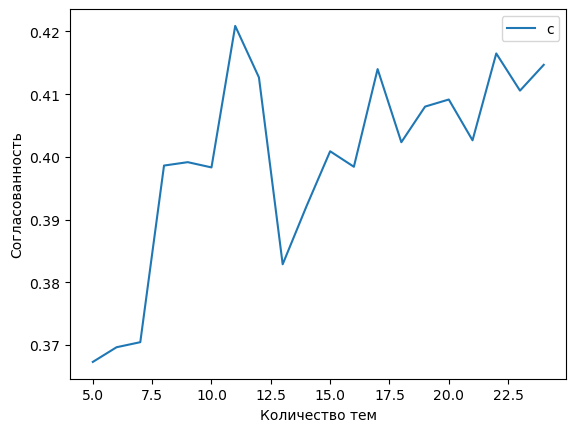

In [34]:
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_ru)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
#plt.suptitle("Качество модели LDA на русском подкорпусе")
plt.show()

In [35]:
lda_model_ru = models.LdaModel(corpus=corpus_tfidf_ru,
                               id2word=dictionary_ru,
                               num_topics=15)

In [36]:
lda_model_ru.print_topics(num_topics=10, num_words=10)

[(9,
  '0.011*"палестинский" + 0.007*"оккупировать" + 0.005*"израильский" + 0.005*"палестина" + 0.005*"иерусалим" + 0.004*"оккупационный" + 0.003*"мученик" + 0.003*"палестинец" + 0.003*"аль-кидва" + 0.002*"израиль"'),
 (1,
  '0.003*"2001/06/27" + 0.003*"2001/03/02" + 0.002*"шельф" + 0.002*"континентальный" + 0.001*"2001/09/10" + 0.001*"2001/09/18" + 0.001*"титульный" + 0.001*"морской" + 0.001*"декабрь" + 0.001*"2001/01/26"'),
 (4,
  '0.004*"оружие" + 0.003*"стрелковый" + 0.003*"вооружение" + 0.002*"марка" + 0.002*"юнмовик" + 0.002*"лёгкий" + 0.002*"ядерный" + 0.002*"разоружение" + 0.002*"quot" + 0.001*"ассамблея"'),
 (14,
  '0.002*"женщина" + 0.002*"княжество" + 0.001*"леса" + 0.001*"выброс" + 0.001*"2001/02/07" + 0.001*"2001/12/19" + 0.001*"2001/02/14" + 0.001*"2001/04/05" + 0.001*"2001/07/16" + 0.001*"ребёнок"'),
 (5,
  '0.006*"quot" + 0.004*"торговля" + 0.004*"развитие" + 0.004*"юнктад" + 0.003*"предпринимательство" + 0.003*"лесной" + 0.003*"рабочий" + 0.003*"страна" + 0.003*"совеща

In [37]:
my_dict_ru = {'Topic_' + str(i): [token for token, score in lda_model_ru.show_topic(i, topn=10)] for i in range(0, lda_model_ru.num_topics)}

In [38]:
my_dict_ru

{'Topic_0': ['2001/11/08',
  'the',
  'e-mail',
  'fax',
  'гибралтар',
  'гибралтарский',
  'and',
  'tel',
  'декабрь',
  'руанда'],
 'Topic_1': ['2001/06/27',
  '2001/03/02',
  'шельф',
  'континентальный',
  '2001/09/10',
  '2001/09/18',
  'титульный',
  'морской',
  'декабрь',
  '2001/01/26'],
 'Topic_2': ['мдп',
  'совет',
  'заседание',
  'безопасность',
  'утверждение',
  'повестка',
  'предварительный',
  'правило',
  'комитет',
  'полномочие'],
 'Topic_3': ['моонрзс',
  'космический',
  'сахара',
  'референдум',
  '2001/10/01',
  '2001/04/09',
  'эстонский',
  'полисарио',
  'западный',
  'пространство'],
 'Topic_4': ['оружие',
  'стрелковый',
  'вооружение',
  'марка',
  'юнмовик',
  'лёгкий',
  'ядерный',
  'разоружение',
  'quot',
  'ассамблея'],
 'Topic_5': ['quot',
  'торговля',
  'развитие',
  'юнктад',
  'предпринимательство',
  'лесной',
  'рабочий',
  'страна',
  'совещание',
  'стандарт'],
 'Topic_6': ['безопасность',
  'совет',
  'письмо',
  'ирак',
  'республика',

## Визуализация

In [ ]:
import pyLDAvis.gensim_models

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_ru, corpus_tfidf_ru, dictionary_ru)
vis



---



---



## LSA Gensim

In [42]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
docs = (d.split() for d in str(docs))

In [ ]:
number_of_topics=10
words=10

In [ ]:
def prepare_corpus(docs):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(docs)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in docs]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(docs,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(docs)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, docs, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

## Визуализация


In [ ]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(docs)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,docs,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(docs,start,stop,step)

In [ ]:
model=create_gensim_lsa_model(docs,number_of_topics,words)

## NMF

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
nmf = NMF(n_components=10, random_state=1, beta_loss="kullback-leibler", solver="mu", max_iter=1000, l1_ratio=0.5)
nmf_model = nmf.fit(docs_vectorized)

In [ ]:
nmf_all_topics = []
print_topics(nmf_model, vectorizer, nmf_all_topics)

In [ ]:
for i,topic in enumerate(nmf_all_topics):
    print("-------------------------------")
    print("Тема ",i)
    for pair in topic:
        print(pair[0])

## Bert

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="russian", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

In [ ]:
topic_model.topics_[:10]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

## W2V 

In [ ]:
from gensim.models import Word2Vec
sg = Word2Vec.load('skip-gram.model')

In [ ]:
for i,topic in enumerate(lda_all_topics):
    list_top = [pair[0] for pair in topic]
    print(list_top)

In [ ]:
# list_tags = [['заболевание_NOUN', 'сердце_NOUN', 'препарат_NOUN'],
# ['стенка_NOUN', 'день_NOUN', 'пациент_NOUN'],
# ['расширить_VERB', 'операция_NOUN', 'врач_NOUN'],
# ['миллиметр_NOUN', 'клапан_NOUN', 'система_NOUN'],
# ['проводить_VERB', 'исследование_NOUN', 'развитие_NOUN'],
# ['норма_NOUN', 'правый_ADJ', 'ребенок_NOUN'],
# ['год_NOUN', 'боль_NOUN', 'болезнь_NOUN'],
# ['левый_ADJ', 'размер_NOUN', 'миллиграмм_NOUN'],
# ['нарушение_NOUN', 'орган_NOUN', 'месяц_NOUN'],
# ['лечение_NOUN', 'изменять_VERB', 'терапия_NOUN']]

In [ ]:
for list_topic in list_tags:
  top = sg.wv.most_similar(positive=list_topic, topn=1)
  print(f'{top}: {list_topic}')